In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
from WindPy import w
%matplotlib inline

In [5]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [180]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[field.lower()] = data
    if len(raw_data.Times) == len(raw_data.Data[0]):
        return pd.DataFrame(dic, index=raw_data.Times)
    else:
        return pd.DataFrame(dic)

In [181]:
df = pd.read_excel('./putwrite.xlsx', index_col=0)

In [182]:
df.head()

,510050.SH,wind_code,option,strike
2015-02-09,2.331,10000009,0.1268,2.35
2015-02-10,2.369,10000009,0.0975,2.35
2015-02-11,2.380,10000010,0.0992,2.40
2015-02-12,2.384,10000010,0.0888,2.40
2015-02-13,2.390,10000010,0.0730,2.40


In [183]:
data = w.wsd('H11025.CSI', 'close', df.index[0].strftime('%Y-%m-%d'), df.index[-1].strftime('%Y-%m-%d'))

In [184]:
df['bond'] = wind2df(data)['close']

In [185]:
df.head()

,510050.SH,wind_code,option,strike,bond
2015-02-09,2.331,10000009,0.1268,2.35,1324.49
2015-02-10,2.369,10000009,0.0975,2.35,1324.65
2015-02-11,2.380,10000010,0.0992,2.40,1324.87
2015-02-12,2.384,10000010,0.0888,2.40,1325.06
2015-02-13,2.390,10000010,0.0730,2.40,1325.24


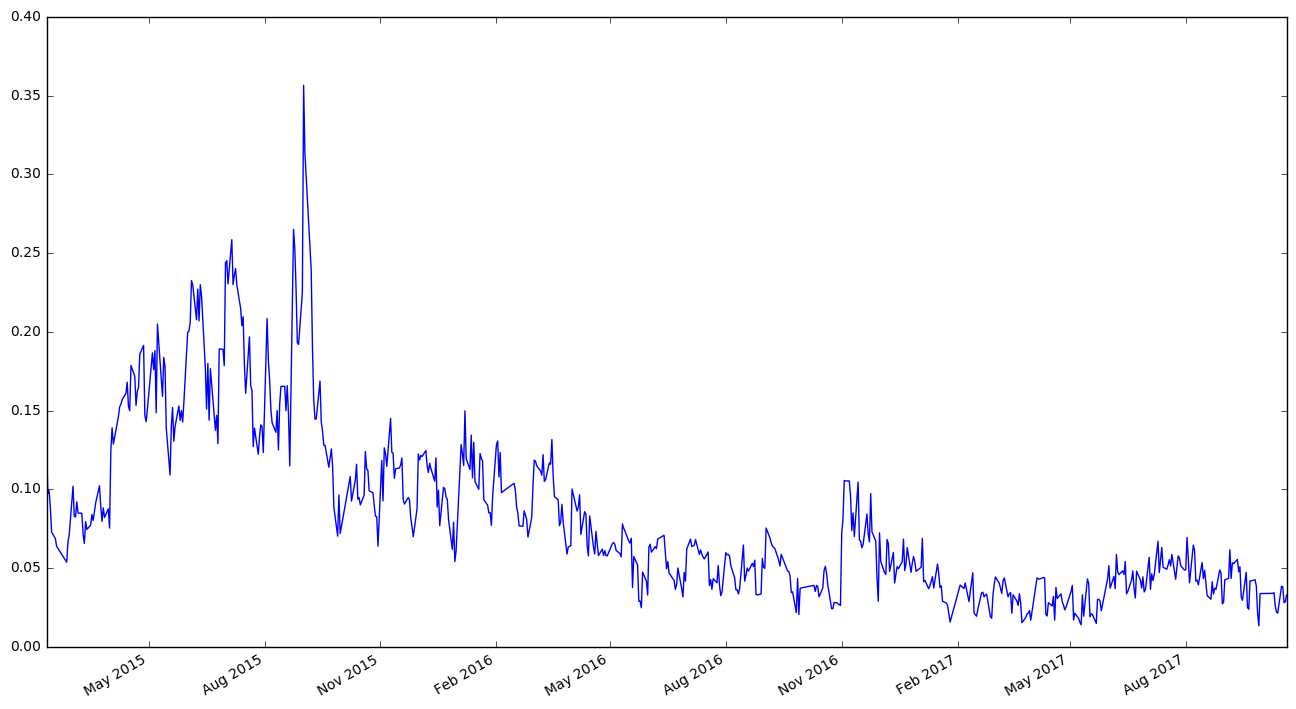

In [186]:
plt.figure(figsize=(16, 9))
df['option'].plot()

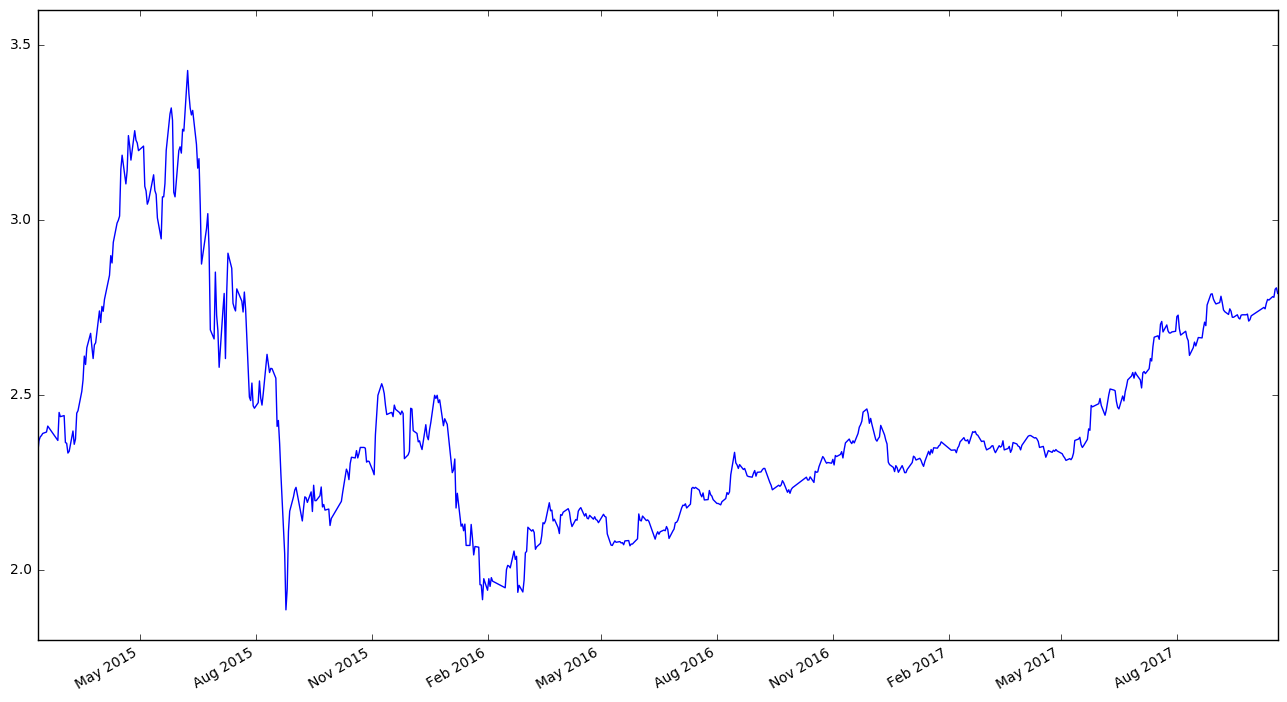

In [187]:
plt.figure(figsize=(16, 9))
df['510050.SH'].plot()

# putwrite策略2
第一天买入可能最大亏损金额那么多的期权

In [189]:
df.loc[:, 'principle'] = 0.
df.loc[:, 'put'] = 0.
df.loc[:, 'margin'] = 0.
principle = 1000000.
one_piece = 10000
possible_loss = 0.5
number = int(principle / (df['strike'][0] * possible_loss) / one_piece)
margin = 0.13
df.loc[:, 'number'] = number

In [190]:
number

85

In [191]:
df['put'] = -(number * df['option'] * one_piece)

In [192]:
df['margin'] = number * one_piece * df['510050.SH'] * margin

In [193]:
df.head()

,510050.SH,wind_code,option,strike,bond,principle,put,margin,number
2015-02-09,2.331,10000009,0.1268,2.35,1324.49,0.0,-107780.0,257575.5,85
2015-02-10,2.369,10000009,0.0975,2.35,1324.65,0.0,-82875.0,261774.5,85
2015-02-11,2.380,10000010,0.0992,2.40,1324.87,0.0,-84320.0,262990.0,85
2015-02-12,2.384,10000010,0.0888,2.40,1325.06,0.0,-75480.0,263432.0,85
2015-02-13,2.390,10000010,0.0730,2.40,1325.24,0.0,-62050.0,264095.0,85


In [194]:
df['principle'] = (principle + df['option'][0] * number * one_piece) - df['margin']

In [195]:
df.head()

,510050.SH,wind_code,option,strike,bond,principle,put,margin,number
2015-02-09,2.331,10000009,0.1268,2.35,1324.49,850204.5,-107780.0,257575.5,85
2015-02-10,2.369,10000009,0.0975,2.35,1324.65,846005.5,-82875.0,261774.5,85
2015-02-11,2.380,10000010,0.0992,2.40,1324.87,844790.0,-84320.0,262990.0,85
2015-02-12,2.384,10000010,0.0888,2.40,1325.06,844348.0,-75480.0,263432.0,85
2015-02-13,2.390,10000010,0.0730,2.40,1325.24,843685.0,-62050.0,264095.0,85


In [196]:
df['interest sum'] = (df['bond'].pct_change() * df['principle']).cumsum()
df.loc[df.index[0], 'interest sum'] = 0

In [197]:
df.head()

,510050.SH,wind_code,option,strike,bond,principle,put,margin,number,interest sum
2015-02-09,2.331,10000009,0.1268,2.35,1324.49,850204.5,-107780.0,257575.5,85,0.000000
2015-02-10,2.369,10000009,0.0975,2.35,1324.65,846005.5,-82875.0,261774.5,85,102.198491
2015-02-11,2.380,10000010,0.0992,2.40,1324.87,844790.0,-84320.0,262990.0,85,242.502572
2015-02-12,2.384,10000010,0.0888,2.40,1325.06,844348.0,-75480.0,263432.0,85,363.590769
2015-02-13,2.390,10000010,0.0730,2.40,1325.24,843685.0,-62050.0,264095.0,85,478.199391


In [198]:
df['total'] = df['principle'] + df['put'] + df['margin'] + df['interest sum']

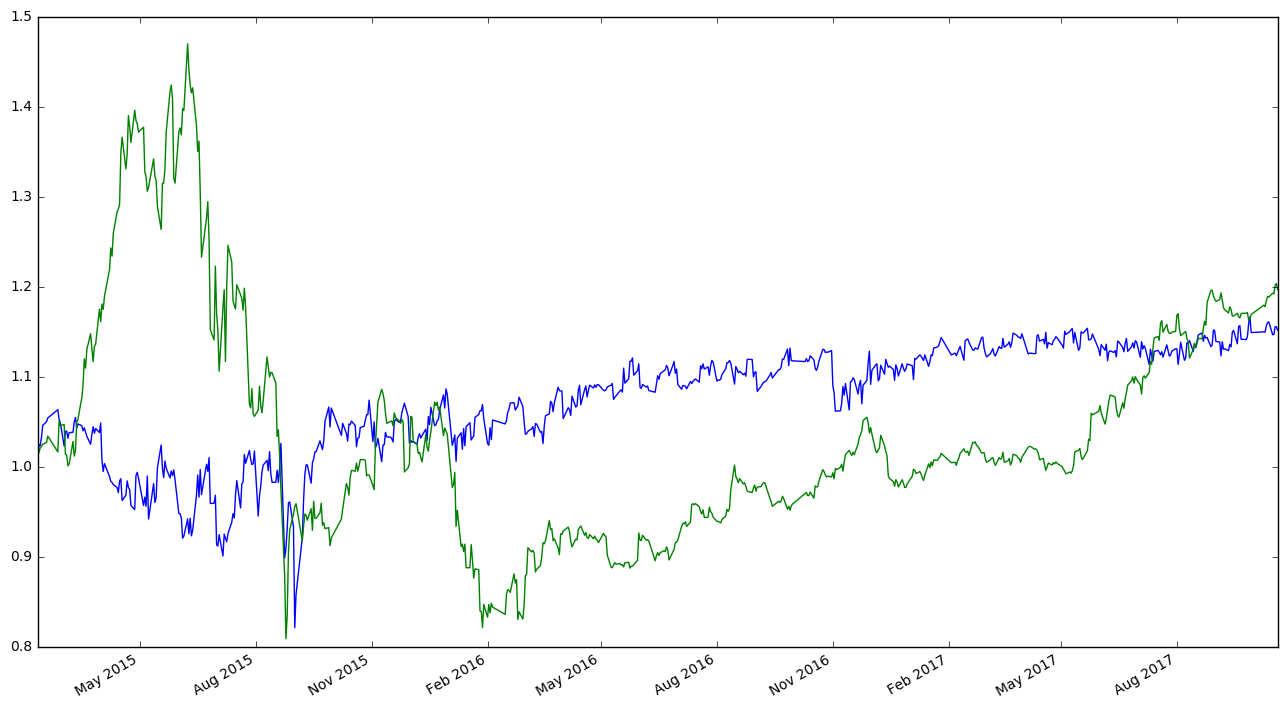

In [199]:
plt.figure(figsize=(16, 9))
(df['total'] / principle).plot()
(1+df['510050.SH'].pct_change()).cumprod().plot()
# (-df['put']/principle).plot()
# (1+df['option'].pct_change()).cumprod().plot()

# putwrite策略2
每个月第一天买入可能最大亏损金额那么多的期权

In [133]:
months = pd.Series([(x.year, x.month) for x in df.index], index=df.index)
rebalance_dates = months.drop_duplicates(keep='first').index

In [136]:
df['principle'] = 0.
df['put'] = 0.
df['margin'] = 0.
df['number'] = 0
principle = 1000000.0
one_piece = 10000
possible_loss = 0.15
margin = 0.13
for date in df.index:
    if date in rebalance_dates:
        number = int(principle / (df.loc[date, 'strike'] * possible_loss) / one_piece)
    df.loc[date, 'number'] = number

In [138]:
df['put'] = -(df['number'] * df['option'] * one_piece)

In [141]:
df['margin'] = df['number'] * one_piece * df['510050.SH'] * margin

In [142]:
df['principle'] = (principle + df['option'][0] * number * one_piece) - df['margin']

In [143]:
df['interest sum'] = (df['bond'].pct_change() * df['principle']).cumsum()
df.loc[df.index[0], 'interest sum'] = 0

In [144]:
df['total'] = df['principle'] + df['put'] + df['margin'] + df['interest sum']

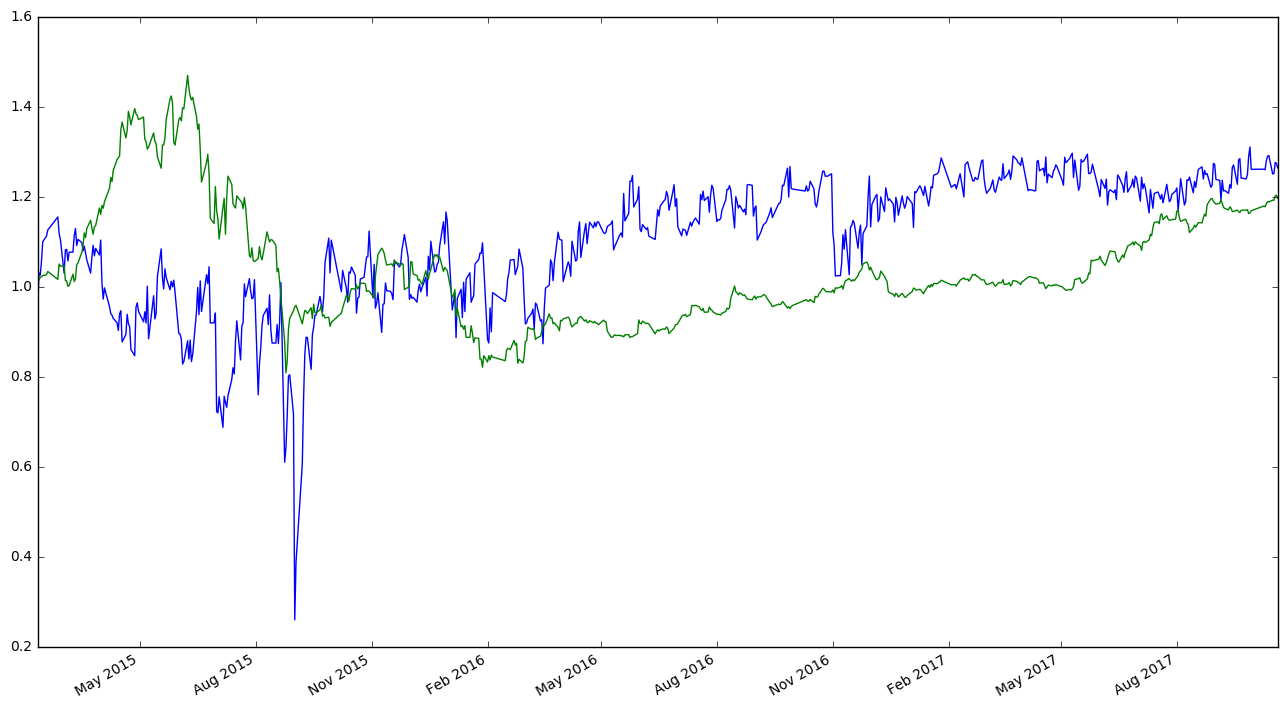

In [145]:
plt.figure(figsize=(16, 9))
(df['total'] / principle).plot()
(1+df['510050.SH'].pct_change()).cumprod().plot()
# (1+df['option'].pct_change()).cumprod().plot()